In [1]:
from dgpsi import dgp, kernel, combine, lgp, path, emulator, Poisson, Hetero, NegBin
import numpy as np
import matplotlib.pyplot as plt

# Example 1 on heteroskedastic Gaussian likelihood

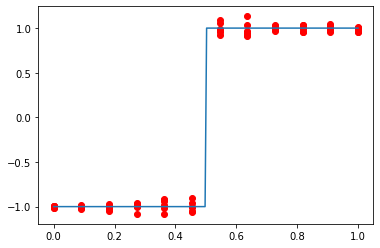

In [4]:
n=12
X=np.linspace(0,1,n)[:,None]
#Create some replications of input positions so that each input position will six different outputs. Note that SI has linear complexity with number of replications. 
for i in range(5):
    X=np.concatenate((X,np.linspace(0,1,n)[:,None]),axis=0)
f1= lambda x: -1. if x<0.5 else 1. #True mean function, which is a step function
f2= lambda x: np.exp(1.5*np.sin((x-0.3)*7.)-6.5) #True variance function, which has higher values around 0.5 but low values around boundaries
Y=np.array([np.random.normal(f1(x),np.sqrt(f2(x))) for x in X]) #Generate stochastic outputs according to f1 and f2
z=np.linspace(0,1.,200)[:,None]
Yz=np.array([f1(x) for x in z]).flatten()
plt.plot(z,Yz) #Plot true mean function
plt.scatter(X,Y,color='r')

In [5]:
#Create a 2-layered DGP + Hetero model
layer1=[kernel(length=np.array([0.5]),name='matern2.5')]
layer2=[kernel(length=np.array([0.2]),name='matern2.5',scale_est=1,connect=np.arange(1)),
kernel(length=np.array([0.2]),name='matern2.5',scale_est=1,connect=np.arange(1))]
layer3=[Hetero()]

In [6]:
#Construct the DGP + Hetero model
all_layer=combine(layer1,layer2,layer3)
m=dgp(X,[Y],all_layer)

In [7]:
#Train the model
m.train(N=500)

Iteration 500: Layer 3: 100%|██████████| 500/500 [00:32<00:00, 15.57it/s]


In [8]:
#Construct the emulator
final_layer_obj=m.estimate()
emu=emulator(final_layer_obj)

In [9]:
#Make predictions across all layers so we can extract predictions for the mean and variance functions
mu,var=emu.predict(z, method='mean_var',full_layer=True)

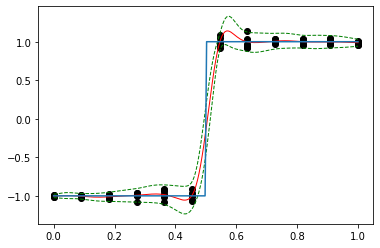

In [10]:
#Visualize the overall model prediction
s=np.sqrt(var[-1])
u=mu[-1]+2*s
l=mu[-1]-2*s
p=plt.plot(z,mu[-1],color='r',alpha=1,lw=1)
p1=plt.plot(z,u,'--',color='g',lw=1)
p1=plt.plot(z,l,'--',color='g',lw=1)
plt.scatter(X,Y,color='black')
plt.plot(z,Yz)

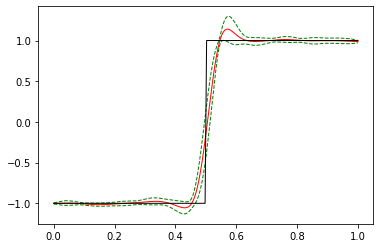

In [11]:
#Visualize the prediction for the mean function
mu_mean=mu[-2][:,0]
var_mean=var[-2][:,0]
s=np.sqrt(var_mean)
u=mu_mean+2*s
l=mu_mean-2*s
p=plt.plot(z,mu_mean,color='r',alpha=1,lw=1)
p1=plt.plot(z,u,'--',color='g',lw=1)
p1=plt.plot(z,l,'--',color='g',lw=1)
plt.plot(z,Yz,color='black',lw=1)

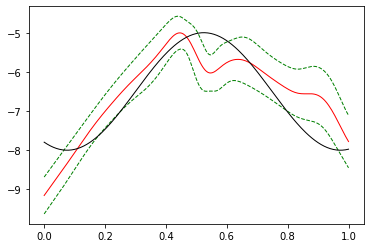

In [12]:
#Visualize the prediction for the log(variance) function
mu_var=mu[-2][:,1]
var_var=var[-2][:,1]
s=np.sqrt(var_var)
u=mu_var+2*s
l=mu_var-2*s
p=plt.plot(z,mu_var,color='r',alpha=1,lw=1)
p1=plt.plot(z,u,'--',color='g',lw=1)
p1=plt.plot(z,l,'--',color='g',lw=1)
plt.plot(z,np.array([np.log(f2(x)) for x in z]).reshape(-1,1),color='black',lw=1)

# Example 2 on heteroskedastic Gaussian likelihood

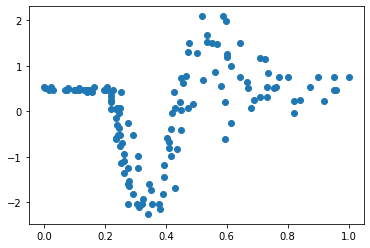

In [19]:
#Load and visualize the motorcycle dataset
X=np.loadtxt('./mc_input.txt').reshape(-1,1)
Y=np.loadtxt('./mc_output.txt').reshape(-1,1)
X=(X-np.min(X))/(np.max(X)-np.min(X))
Y=(Y-Y.mean())/Y.std()
plt.scatter(X,Y)

In [21]:
#Construct a 2-layered DGP + Hetero model
layer1=[kernel(length=np.array([0.5]),name='sexp')]
layer2=[]
for _ in range(2):
    k=kernel(length=np.array([0.2]),name='sexp',scale_est=1,connect=np.arange(1))
    layer2.append(k)
layer3=[Hetero()]

all_layer=combine(layer1,layer2,layer3)
m=dgp(X,[Y],all_layer)

In [22]:
#Train the model
m.train(N=500)

Iteration 500: Layer 3: 100%|██████████| 500/500 [04:26<00:00,  1.87it/s]


In [23]:
#Construct the emulator
final_layer_obj=m.estimate()
emu=emulator(final_layer_obj)

In [24]:
#Make predictions over [0,1]
z=np.linspace(0,1,100)[:,None]
mu,var=emu.predict(z, method='mean_var')

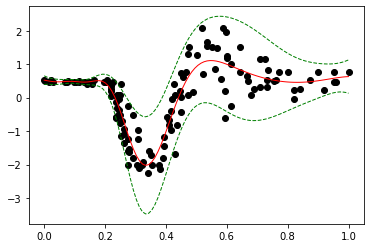

In [25]:
#Visualize the predictions
s=np.sqrt(var)
u=mu+2*s
l=mu-2*s
p=plt.plot(z,mu,color='r',alpha=1,lw=1)
p1=plt.plot(z,u,'--',color='g',lw=1)
p1=plt.plot(z,l,'--',color='g',lw=1)
plt.scatter(X,Y,color='black')

# Example 3 on Poisson likelihood

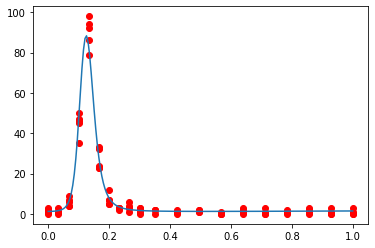

In [31]:
#Generate some data with replications
n=10
X=np.linspace(0,.3,n)[:,None]
for _ in range(4):
    X=np.concatenate((X,np.linspace(0,.3,n)[:,None]),axis=0)
    X=np.concatenate((X,np.linspace(0.35,1,n)[:,None]),axis=0)
f= lambda x: np.exp(np.exp(-1.5*np.sin(1/((0.7*0.8*(1.5*x+0.1)+0.3)**2))))
Y=np.array([np.random.poisson(f(x)) for x in X]).reshape(-1,1)
z=np.linspace(0,1.,200)[:,None]
Yz=np.array([f(x) for x in z]).flatten()
plt.plot(z,Yz)
plt.scatter(X,Y,color='r')


In [32]:
#Train a GP + Poisson model
layer1=[kernel(length=np.array([0.5]),name='matern2.5',scale_est=1)]
layer2=[Poisson()]
all_layer=combine(layer1,layer2)
m=dgp(X,[Y],all_layer)
m.train(N=500)

Iteration 500: Layer 2: 100%|██████████| 500/500 [00:10<00:00, 48.16it/s]


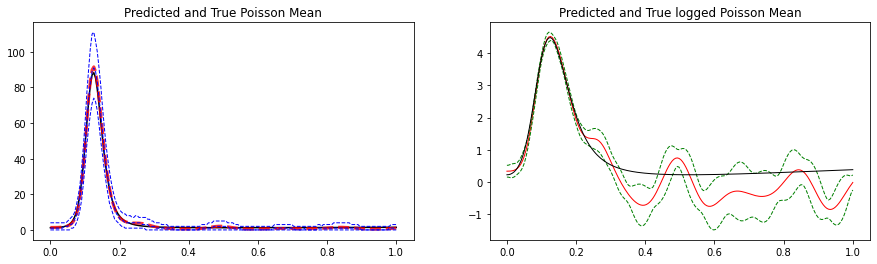

In [33]:
#Visualize the results
final_layer_obj=m.estimate()
emu=emulator(final_layer_obj)
mu,var=emu.predict(z, method='mean_var',full_layer=True) #Make mean-variance prediction
samp=emu.predict(z, method='sampling') #Draw some samples to obtain the quantiles of the overall model
quant=np.quantile(np.squeeze(samp), [0.05,0.5,0.95],axis=1) #Compute sample-based quantiles
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
ax1.set_title('Predicted and True Poisson Mean')
ax1.plot(z,Yz,color='black')
ax1.plot(z,mu[-1],'--',color='red',alpha=0.8,lw=3)
ax1.plot(z,quant[0,:],'--',color='b',lw=1)
ax1.plot(z,quant[1,:],'--',color='b',lw=1)
ax1.plot(z,quant[2,:],'--',color='b',lw=1)
mu_gp, var_gp=mu[-2], var[-2]
s=np.sqrt(var_gp)
u,l =mu_gp+2*s, mu_gp-2*s
ax2.set_title('Predicted and True logged Poisson Mean')
ax2.plot(z,mu_gp,color='r',alpha=1,lw=1)
ax2.plot(z,u,'--',color='g',lw=1)
ax2.plot(z,l,'--',color='g',lw=1)
ax2.plot(z,np.log(Yz),color='black',lw=1)

In [34]:
#Train a 2-layered DGP + Poisson model
layer1=[kernel(length=np.array([0.5]),name='matern2.5')]
layer2=[kernel(length=np.array([0.1]),name='matern2.5',scale_est=1,connect=np.arange(1))]
layer3=[Poisson()]
all_layer=combine(layer1,layer2,layer3)
m=dgp(X,[Y],all_layer)
m.train(N=500)

Iteration 500: Layer 3: 100%|██████████| 500/500 [00:24<00:00, 20.27it/s]


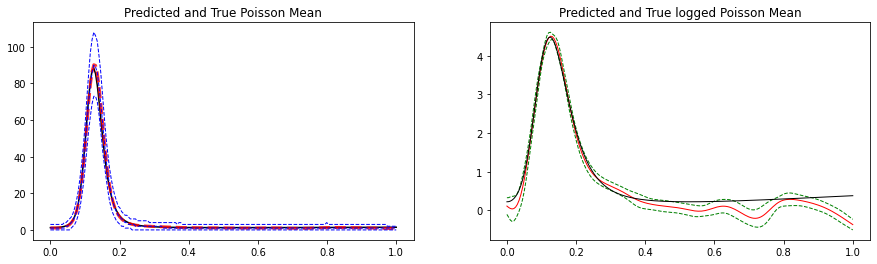

In [35]:
#Visualize the results
final_layer_obj=m.estimate()
emu=emulator(final_layer_obj)
mu,var=emu.predict(z, method='mean_var',full_layer=True) #Make mean-variance prediction
samp=emu.predict(z, method='sampling') #Draw some samples to obtain the quantiles of the overall model
quant=np.quantile(np.squeeze(samp), [0.05,0.5,0.95],axis=1) #Compute sample-based quantiles
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
ax1.set_title('Predicted and True Poisson Mean')
ax1.plot(z,Yz,color='black')
ax1.plot(z,mu[-1],'--',color='red',alpha=0.8,lw=3)
ax1.plot(z,quant[0,:],'--',color='b',lw=1)
ax1.plot(z,quant[1,:],'--',color='b',lw=1)
ax1.plot(z,quant[2,:],'--',color='b',lw=1)
mu_gp, var_gp=mu[-2], var[-2]
s=np.sqrt(var_gp)
u,l =mu_gp+2*s, mu_gp-2*s
ax2.set_title('Predicted and True logged Poisson Mean')
ax2.plot(z,mu_gp,color='r',alpha=1,lw=1)
ax2.plot(z,u,'--',color='g',lw=1)
ax2.plot(z,l,'--',color='g',lw=1)
ax2.plot(z,np.log(Yz),color='black',lw=1)

# Example 4 on Negative Binomial likelihood
The Negative Binomial pmf in dgpsi is defined by
$$p_Y(y;\mu,\sigma)=\frac{\Gamma(y+\frac{1}{\sigma})}{\Gamma(1/{\sigma})\Gamma(y+1)}\left(\frac{\sigma\mu}{1+\sigma\mu}\right)^y\left(\frac{1}{1+\sigma\mu}\right)^{1/{\sigma}}$$
with mean $0<\mu<\infty$ and disperion $0<\sigma<\infty$, which correspond to numpy's negative binomial parameters $n$ and $p$ via $n=1/\sigma$ and $p=1/(1+\mu\sigma)$.

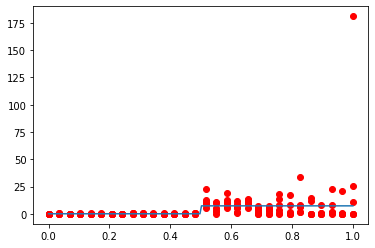

In [167]:
#Generate some data from the Negative Binomial distribution.
n=30
X=np.linspace(0,1,n)[:,None]
for _ in range(5):
    X=np.concatenate((X,np.linspace(0,1,n)[:,None]),axis=0)
f1= lambda x: 1/np.exp(2) if x<0.5 else np.exp(2) #True mean function
f2= lambda x: np.exp(6*x**2-3) #True dispersion function
Y=np.array([np.random.negative_binomial(1/f2(x),1/(1+f1(x)*f2(x))) for x in X]).reshape(-1,1)
Xt=np.linspace(0,1.,200)[:,None]
Yt=np.array([f1(x) for x in Xt]).flatten()
plt.plot(Xt,Yt)
plt.scatter(X,Y,color='r')

In [168]:
#Train a 2-layered DGP (one GP in the first layer and two in the second corresponding to the mean and dispersion parameters) + NegBin model
layer1=[kernel(length=np.array([0.5]),name='matern2.5')]
layer2=[kernel(length=np.array([0.02]),name='matern2.5',scale_est=1,connect=np.arange(1)),
kernel(length=np.array([0.02]),name='matern2.5',scale_est=1,connect=np.arange(1))]
layer3=[NegBin()]
all_layer=combine(layer1,layer2,layer3)
m=dgp(X,[Y],all_layer)
m.train(N=500)

Iteration 500: Layer 3: 100%|██████████| 500/500 [01:10<00:00,  7.13it/s]


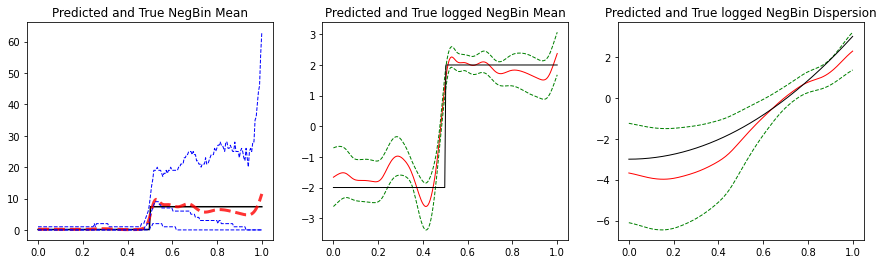

In [169]:
#Visualize the results
final_layer_obj=m.estimate()
emu=emulator(final_layer_obj)
mu,var=emu.predict(Xt, method='mean_var',full_layer=True) #Make mean-variance prediction
samp=emu.predict(Xt, method='sampling') #Draw some samples to obtain the quantiles of the overall model
quant=np.quantile(np.squeeze(samp), [0.05,0.5,0.95],axis=1) #Compute sample-based quantiles
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))
ax1.set_title('Predicted and True NegBin Mean')
ax1.plot(Xt,Yt,color='black')
ax1.plot(Xt,mu[-1],'--',color='red',alpha=0.8,lw=3)
ax1.plot(Xt,quant[0,:],'--',color='b',lw=1)
ax1.plot(Xt,quant[1,:],'--',color='b',lw=1)
ax1.plot(Xt,quant[2,:],'--',color='b',lw=1)
mu_gp, var_gp=mu[-2][:,0], var[-2][:,0]
s=np.sqrt(var_gp)
u,l =mu_gp+2*s, mu_gp-2*s
ax2.set_title('Predicted and True logged NegBin Mean')
ax2.plot(Xt,mu_gp,color='r',alpha=1,lw=1)
ax2.plot(Xt,u,'--',color='g',lw=1)
ax2.plot(Xt,l,'--',color='g',lw=1)
ax2.plot(Xt,np.log(Yt),color='black',lw=1)
mu_gp, var_gp=mu[-2][:,1], var[-2][:,1]
s=np.sqrt(var_gp)
u,l =mu_gp+2*s, mu_gp-2*s
ax3.set_title('Predicted and True logged NegBin Dispersion')
ax3.plot(Xt,mu_gp,color='r',alpha=1,lw=1)
ax3.plot(Xt,u,'--',color='g',lw=1)
ax3.plot(Xt,l,'--',color='g',lw=1)
ax3.plot(Xt,np.array([np.log(f2(x)) for x in Xt]).reshape(-1,1),color='black',lw=1)